In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'elephants.png'
# Python Imaging Library(PIL)
img = image.load_img(img_path, target_size=(224, 224))

# float32 numpy array of shape (224, 224, 3)
x = image.img_to_array(img)
# adds a dimiension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
# preprocesses the batch (this does channel-wise color normalization)
x = preprocess_input(x)

In [3]:
preds = model.predict(x)

In [4]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.8765623), ('n01871265', 'tusker', 0.11419991), ('n02504013', 'Indian_elephant', 0.009071713)]


In [5]:
np.argmax(preds[0])

386

In [6]:
from tensorflow.keras import backend as K

# african elephant entry prediction vector
african_elephant_output = model.output[:, 386]

# output feature map of the block5_conv3 layer, the last convolution layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# values of these two quantities, as Numpy arrays, given the sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

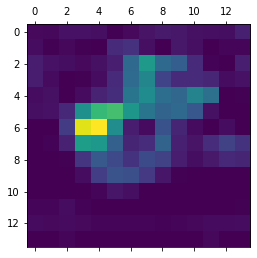

In [7]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

In [12]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephants_cam.png', superimposed_img)

True